-------------
### ライブラリのインポート

In [2]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
### 実験設定

In [3]:
TARGET = "visit"  #'conversion', 'visit'
TRAIN_SIZE = 100000
TEST_SIZE = 100000
THRESHOLD_LIST = [2]  # 外れ値除外の閾値

RANDOM_STATE = 0  # 乱数シード

-----------
### データの前処理

In [6]:
df_all = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\criteo-uplift-v2.1.csv.gz", sep=",", header=None
)

df_all.columns = df_all.iloc[0]  # 0行目を列名にする
df_all = df_all[1:].reset_index(drop=True)

column_names = df_all.columns.tolist()
print("列名:", column_names)

df_treatment = df_all[df_all["treatment"] == 1]
df_treatment_0 = df_treatment[df_treatment[TARGET] == 0]
df_treatment_1 = df_treatment[df_treatment[TARGET] == 1]
print(df_treatment.shape)
print(df_treatment_0.shape)
print(df_treatment_1.shape)

features_list = [
    "f0",
    "f1",
    "f2",
    "f3",
    "f4",
    "f5",
    "f6",
    "f7",
    "f8",
    "f9",
    "f10",
    "f11",
]
ALL_FEATURES_INDEX = [i for i in range(len(features_list))]

df_train_0 = df_treatment_0.iloc[: int(TRAIN_SIZE / 2)]
df_train_1 = df_treatment_1.iloc[: int(TRAIN_SIZE / 2)]
df_test_0 = df_treatment_0.iloc[
    int(TRAIN_SIZE / 2) : int(TRAIN_SIZE / 2 + TEST_SIZE / 2)
]
df_test_1 = df_treatment_1.iloc[
    int(TRAIN_SIZE / 2) : int(TRAIN_SIZE / 2 + TEST_SIZE / 2)
]

df_train = pd.concat([df_train_0, df_train_1])
df_test = pd.concat([df_test_0, df_test_1])
print(df_train.shape)
print(df_test.shape)


C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_3824\478778226.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(


列名: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'treatment', 'conversion', 'visit', 'exposure']
(11849888, 16)
(11273895, 16)
(575993, 16)
(200000, 16)
(200000, 16)


-------------
### 外れ値を除外しない場合

In [7]:
df = df_train

全データ数： 200000
0のデータ数： 100000
1のデータ数： 100000
分散： 0.25


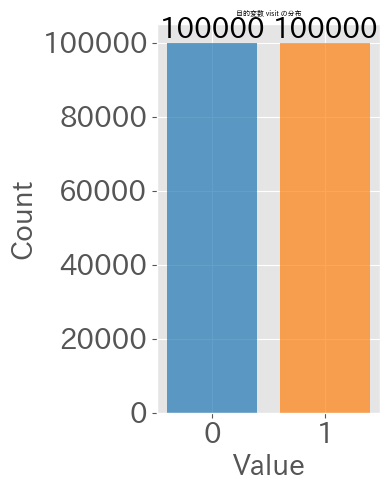

In [8]:
y = df[TARGET]
print("全データ数：", len(df))
print("0のデータ数：", len(y[y == 0]))
print("1のデータ数：", len(y[y == 1]))
print("分散：", np.var(y))
# 値が0と1のデータ数を計算
counts = y.value_counts()
labels = counts.index  # [0, 1]
values = counts.values  # [count_0, count_1]

# プロット
fig, ax = plt.subplots(figsize=(4, 5))
bars = ax.bar(labels, values, color=["#1f77b4", "#ff7f0e"], alpha=0.7)

# 各バーの上に数値を表示
for bar, value in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # バーの中央
        bar.get_height(),  # バーの高さ
        f"{value}",  # 表示する数値
        ha="center",
        va="bottom",
        fontsize=20,
    )

# ラベルとタイトルを設定
ax.set_title(f"目的変数 {TARGET} の分布", fontsize=5)
ax.set_xlabel("Value", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_xticks([0, 1])  # 横軸の位置を0と1に設定
ax.set_xticklabels(["0", "1"], fontsize=20)  # ラベルを明示的に指定
ax.tick_params(axis="both", labelsize=20)

plt.tight_layout()
plt.show()

-------------
### 外れ値除外

In [9]:
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

In [10]:
for i in range(len(THRESHOLD_LIST)):
    df_outliers_removed = remove_outliers_zscore(
        data=df, metric=TARGET, threshold=THRESHOLD_LIST[i]
    )
    df_outliers_removed = df_outliers_removed.reset_index(drop=True)  # 行を詰める
    y = df_outliers_removed[TARGET]
    print(f"閾値：{THRESHOLD_LIST[i]}")
    print("外れ値除外前のデータ数（訓練+テスト）:", len(df_train))
    print("外れ値除外後のデータ数（訓練+テスト）:", len(df_outliers_removed))
    print("除外されたデータ数：", len(df_train) - len(df_outliers_removed))

    counts = y.value_counts()
    labels = counts.index  # [0, 1]
    values = counts.values  # [count_0, count_1]

    # プロット
    fig, ax = plt.subplots(figsize=(4, 5))
    bars = ax.bar(labels, values, color=["#1f77b4", "#ff7f0e"], alpha=0.7)

    # 各バーの上に数値を表示
    for bar, value in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # バーの中央
            bar.get_height(),  # バーの高さ
            f"{value}",  # 表示する数値
            ha="center",
            va="bottom",
            fontsize=20,
        )

    # ラベルとタイトルを設定
    ax.set_title(f"目的変数 {TARGET} の分布", fontsize=5)
    ax.set_xlabel("Value", fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    ax.set_xticks([0, 1])  # 横軸の位置を0と1に設定
    ax.set_xticklabels(["0", "1"], fontsize=20)  # ラベルを明示的に指定
    ax.tick_params(axis="both", labelsize=20)

    plt.tight_layout()
    plt.show()

TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method